In [8]:
from src.models.vit_continuous_module import ViTContinuousLitModule
from src.models.components.tokenized_vit_continuous import TokenizedViTContinuous

In [9]:
TASK_TO_RANGE = {
    '3days': 72,
    '5days': 120,
    '7days': 168
}

In [10]:
var = 'z_500'
task = '3days'
pred_range = TASK_TO_RANGE[task]

In [11]:
net_args = {
    'climate_modeling': False,
    'time_history': 1,
    'img_size': [128,256],
    'patch_size': 4,
    'default_vars': [
      "land_sea_mask",
      "orography",
      "lattitude",
      "2m_temperature",
      "10m_u_component_of_wind",
      "10m_v_component_of_wind",
      # "toa_incident_solar_radiation",
      # 'total_precipitation',
      "geopotential_50",
      "geopotential_250",
      "geopotential_500",
      "geopotential_600",
      "geopotential_700",
      "geopotential_850",
      "geopotential_925",
      "u_component_of_wind_50",
      "u_component_of_wind_250",
      "u_component_of_wind_500",
      "u_component_of_wind_600",
      "u_component_of_wind_700",
      "u_component_of_wind_850",
      "u_component_of_wind_925",
      "v_component_of_wind_50",
      "v_component_of_wind_250",
      "v_component_of_wind_500",
      "v_component_of_wind_600",
      "v_component_of_wind_700",
      "v_component_of_wind_850",
      "v_component_of_wind_925",
      "temperature_50",
      "temperature_250",
      "temperature_500",
      "temperature_600",
      "temperature_700",
      "temperature_850",
      "temperature_925",
      "relative_humidity_50",
      "relative_humidity_250",
      "relative_humidity_500",
      "relative_humidity_600",
      "relative_humidity_700",
      "relative_humidity_850",
      "relative_humidity_925",
      "specific_humidity_50",
      "specific_humidity_250",
      "specific_humidity_500",
      "specific_humidity_600",
      "specific_humidity_700",
      "specific_humidity_850",
      "specific_humidity_925",
    ],
    'out_vars': [var],
    'channel_agg': "attention",
    'embed_dim': 1024,
    'depth': 8,
    'decoder_depth': 2,
    'num_heads': 16,
    'mlp_ratio': 4.0,
    'init_mode': "small",
}

net = TokenizedViTContinuous(**net_args)

In [12]:
model = ViTContinuousLitModule(
    net = net,
    pretrained_path = f'/datadrive/datasets/checkpoints/finetuned/1.40625deg/mpi_tai_awi_hammoz_cmcc/1024dim/{var}/{task}/best.ckpt'
)

Loading pre-trained checkpoint from: /datadrive/datasets/checkpoints/finetuned/1.40625deg/mpi_tai_awi_hammoz_cmcc/1024dim/z_500/3days/best.ckpt
<All keys matched successfully>


In [13]:
from src.datamodules.finetune_module import ERA5IterDatasetContinuousModule

In [14]:
datamodule = ERA5IterDatasetContinuousModule(
    root_dir=f'/datadrive/datasets/era5_forecast_1.40625deg_{task}/',
    variables=[
      "lsm",
      "orography",
      "lat2d",
      "t2m",
      "u10",
      "v10",
      # "tisr",
      # 'tp',
      "z_50",
      "z_250",
      "z_500",
      "z_600",
      "z_700",
      "z_850",
      "z_925",
      "u_50",
      "u_250",
      "u_500",
      "u_600",
      "u_700",
      "u_850",
      "u_925",
      "v_50",
      "v_250",
      "v_500",
      "v_600",
      "v_700",
      "v_850",
      "v_925",
      "t_50",
      "t_250",
      "t_500",
      "t_600",
      "t_700",
      "t_850",
      "t_925",
      "r_50",
      "r_250",
      "r_500",
      "r_600",
      "r_700",
      "r_850",
      "r_925",
      "q_50",
      "q_250",
      "q_500",
      "q_600",
      "q_700",
      "q_850",
      "q_925",
    ],
    out_variables=[var],
    region='Global',
    predict_range=pred_range,
    hrs_each_step=1,
    buffer_size=2000,
    batch_size=1
)

In [15]:
datamodule.set_patch_size(model.get_patch_size())

normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)

In [16]:
datamodule.setup()

In [24]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime

def visualize_forecast(model_module, data_module, pred_task, var_name, save_path = None):
    model_module.eval()
    model_module.cuda()

    dataloader = data_module.test_dataloader()
    x, y, lead_times, in_vars, out_vars, region_info = next(iter(dataloader))
    x = x.cuda()
    y = y.cuda()
    lead_times = lead_times.cuda()

    fig, axes = plt.subplots(1, 4, figsize=(28, 3), squeeze = False)
    
    with torch.no_grad():
        _, pred = model_module.net.forward(x, y, lead_times, in_vars, out_vars, region_info, None, model_module.lat)
    
    var_id = model_module.net.get_channel_ids(out_vars)
    x = x[:, :, var_id]

    inv_normalize = model_module.denormalization
    init_condition, gt = inv_normalize(x), inv_normalize(y)
    pred = inv_normalize(pred)
    bias = pred - gt
    
    index = 0

    for i, tensor in enumerate([init_condition, gt, pred, bias]):
        ax = axes[index][i]
        im = ax.imshow(tensor.detach().squeeze().cpu().numpy())
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        ) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False
        ) # labels along the bottom edge are off

    axes[index][0].text(-10, 64, var_name, fontsize=28, rotation=90, va='center', ha='center')
    axes[index][0].set_title(f"Initial condition", fontsize='xx-large')
    axes[index][1].set_title(f"Ground truth", fontsize='xx-large')
    axes[index][2].set_title(f"{pred_task} Prediction", fontsize='xx-large')
    axes[index][3].set_title(f"Bias", fontsize='xx-large')

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0.025, hspace=0.025,)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
        
    del x
    del y
    del pred

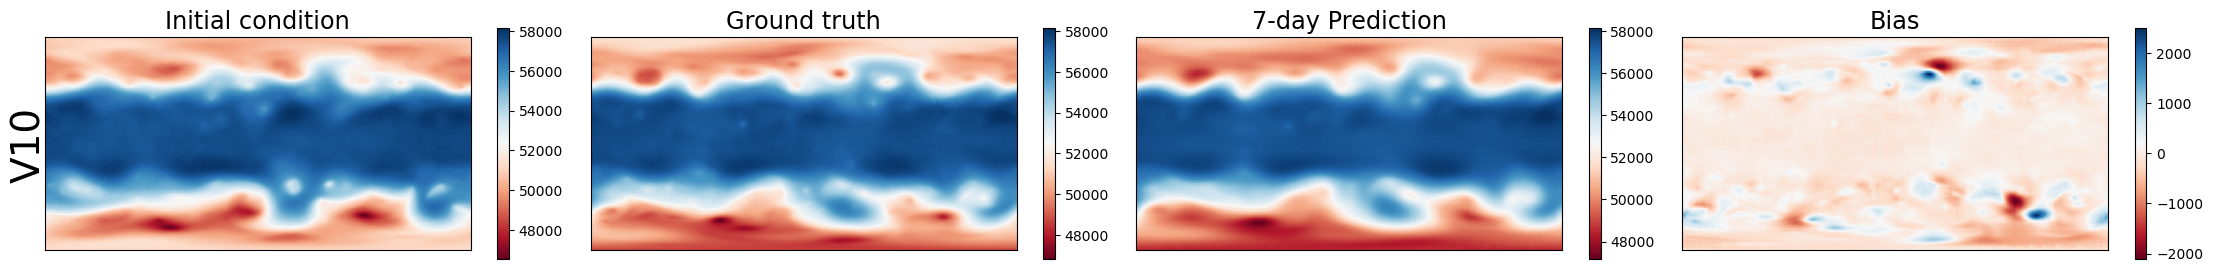

In [25]:
visualize_forecast(model, datamodule, '3-day', 'Z500', 'forecast_z500_3days.png')